In [1]:
##%matplotlib widget
## with %matplotlib notebook: seems to require ipympl as part of environment, either
## part of the conda environment or "pip install ipympl"
## otherwise, does not show ANY plots in notebook, plt.savefig() works
%matplotlib notebook  
##%matplotlib inline    ## --plt.savefig()  works, but re-sizing does NOT

This notebook is a short demo to illustrate execution.   For odd historical reasons, it uses "toy Monte Carlo" (simulated data)for "training" and "full LHCB MC" for validation.

The network architecture is a "simple" model that uses 1 input channel (the KDE [kernel density estimator] but from the track parameters) feeding 5 convolutional layers followed by a fully connected layer.

In today's version, the network will start with weights from a previously trained version.
 

Check the current GPU usage. Please try to be nice!

In [2]:
!nvidia-smi

Thu Jan 14 15:55:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN V             Off  | 00000000:03:00.0 Off |                  N/A |
| 26%   32C    P0    31W / 250W |      0MiB / 12066MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   33C    P0    33W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

> **WARNING**: The card numbers here are *not* the same as in CUDA. You have been warned.

## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pandas as pd
import mlflow

# Python 3 standard library
from pathlib import Path

from torchsummary import summary

'''
HELPER FUNCTIONS
'''
# From model/collectdata.py
from model.collectdata_mdsA import collect_data

# From model/loss.py
##from loss import Loss
from model.alt_loss_A import Loss

# From model/training.py
from model.training import trainNet, select_gpu, Results

# From model/models.py
##  will start with model from TwoFeatures_CNN6Layer_A in the first instance
##  see relevant cell below

from model.models_mjp_19November20 import All_CNN6Layer_A as ModelA
from model.models_mjp_19November20 import All_CNN6Layer_E as ModelE
from model.models_mjp_19November20 import All_CNN8Layer_W as ModelW
from model.models_mjp_26December20 import All_CNN10Layer_X as ModelX
from model.models_mjp_26December20 import All_CNN8Layer_Y as ModelY

# From model/utilities.py
from model.utilities import load_full_state, count_parameters, Params

from model.plots import dual_train_plots, replace_in_ax

## adds image of model architecture
import hiddenlayer as HL

Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [4]:
device = select_gpu(0)

1 available GPUs (initially using device 0):
  0 TITAN V


### Set up local parameters

In [5]:
# params order - batch size, epochs, lr, epoch_start (which is usually set to 0)
args = Params(128, 200, 1e-3, 220)

## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

In [6]:
## newer vernacular
## Training dataset. You can put as many files here as desired.

## in this DEMO example we use only one 80K training set -- the model starts with well-trained weights,
## and using a smaller training set reduces both the time to load the data and the time to train an epoch
##  set the option load_XandXsq = True to use both DKE and KDE^2 as input features
train_loader = collect_data('/share/lazy/sokoloff/ML-data_A/Aug14_80K_train.h5',
                             '/share/lazy/sokoloff/ML-data_AA/Oct03_80K_train.h5',
#                             '/share/lazy/sokoloff/ML-data_AA/Oct03_40K_train.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_1.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_3.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_4.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_5.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_6.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_7.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_8.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_9.h5',
                            #'/share/lazy/sokoloff/ML-data_AA/Oct03_80K2_train.h5',
                             batch_size=args.batch_size,
## if we are using a larger dataset (240K events, with the datasets above, and 11 GB  of GPU memory),
## not the dataset will overflow the GPU memory; device=device will allow the data to move back
## and forth between the CPU and GPU memory. While this allows use of a larger dataset, it slows
## down performance by about 10%.  So comment out when not needed.
                            device=device,
                            masking=True, shuffle=True,
                            load_XandXsq=False,
                            load_xy=False)

# Validation dataset. You can slice to reduce the size.
## dataAA -> /share/lazy/sokoloff/ML-data_AA/
val_loader = collect_data('/share/lazy/sokoloff/ML-data_AA/Oct03_20K_val.h5',
## mds val_loader = collect_data('dataAA/HLT1CPU_1kevts_val.h5',

                          batch_size=args.batch_size,
                          slice=slice(256 * 39),
                          device=device,
                          masking=True, shuffle=False,
                          load_XandXsq=False,
                          load_xy=False)

Loading data...
Loaded /share/lazy/sokoloff/ML-data_A/Aug14_80K_train.h5 in 10.46 s
Loaded /share/lazy/sokoloff/ML-data_AA/Oct03_80K_train.h5 in 10.76 s
Constructing 160000 event dataset took 3.356 s
Loading data...
Loaded /share/lazy/sokoloff/ML-data_AA/Oct03_20K_val.h5 in 2.548 s
Constructing 9984 event dataset took 0.05882 s


# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [7]:
model = ModelY()

##summary(model, input_size=(4, 4000))
##print(model.parameters)

mlflow.tracking.set_tracking_uri('file:/share/lazy/pv-finder_model_repo')
mlflow.set_experiment('Four Feature AllCNN')

Traceback (most recent call last):
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 197, in list_experiments
    experiment = self._get_experiment(exp_id, view_type)
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 260, in _get_experiment
    meta = read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/utils/file_utils.py", line 167, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
mlflow.exceptions.MissingConfigException: Yaml file '/share/lazy/pv-finder_model_repo/ML/meta.yaml' does not exist.


In [8]:
print("Let's use", torch.cuda.device_count(), "GPUs!")
if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)

Let's use 1 GPUs!


In [9]:
##  mds 200121 loss = Loss(epsilon=1e-5,coefficient=1.0)
loss = Loss(epsilon=1e-5,coefficient=2.5)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

##  use the first five layers from a pre-existing model
##  see example at https://discuss.pytorch.org/t/how-to-load-part-of-pre-trained-model/1113
##   ML -> /share/lazy/sokoloff/ML

#path = 'run_stats.pyt'
#load_full_state(model, optimizer, path, freeze_weights=True)
# For other pretrained models, go to MLFlow and find the path for "run_stats.pyt"
pretrained_dict = '/share/lazy/pv-finder_model_repo/12/da7c2ca894234d7999ef8b8e8c3b7833/artifacts/run_stats.pyt'
load_full_state(model, optimizer, pretrained_dict, freeze_weights=True)

we also froze 7 weights
Of the 28.0 parameter layers to update in the current model, 7.0 were loaded


Let's move the model's weight matricies to the GPU:

In [10]:
model.to(device)

All_CNN8Layer_Y(
  (conv1): Conv1d(1, 20, kernel_size=(25,), stride=(1,), padding=(12,))
  (conv2): Conv1d(20, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv3): Conv1d(30, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv4): Conv1d(40, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv5): Conv1d(50, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv6): Conv1d(60, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv7): Conv1d(70, 1, kernel_size=(5,), stride=(1,), padding=(2,))
  (finalFilter): Conv1d(71, 1, kernel_size=(91,), stride=(1,), padding=(45,))
  (conv1dropout): Dropout(p=0.15, inplace=False)
  (conv2dropout): Dropout(p=0.15, inplace=False)
  (conv3dropout): Dropout(p=0.15, inplace=False)
  (conv4dropout): Dropout(p=0.15, inplace=False)
  (conv5dropout): Dropout(p=0.15, inplace=False)
  (conv6dropout): Dropout(p=0.15, inplace=False)
  (conv7dropout): Dropout(p=0.15, inplace=False)
  (bn1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=Tru

## Train 



The body of this loop runs once per epoch. Results is a named tuple of values (loss per epoch for training and validation, time each). Start by setting up a plot first:

<IPython.core.display.Javascript object>


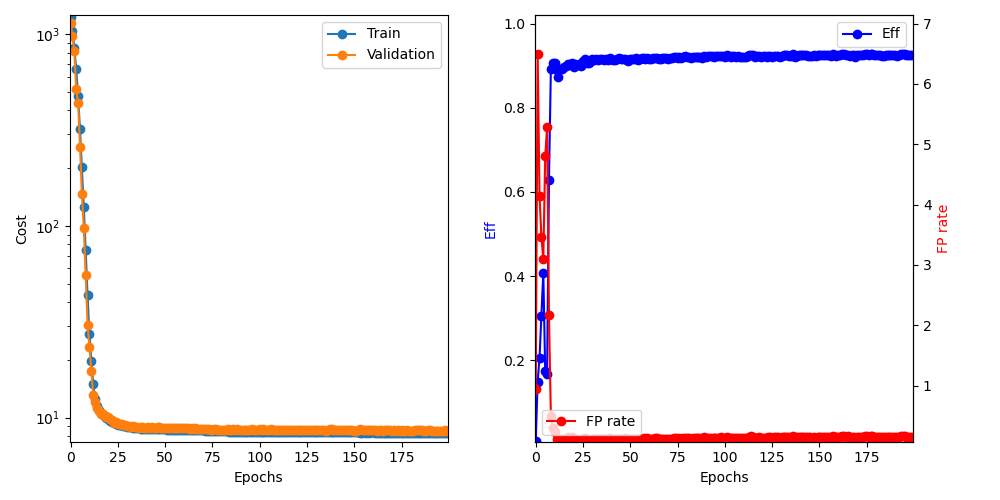

In [11]:
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)

for model:  All_CNN8Layer_Y(
  (conv1): Conv1d(1, 20, kernel_size=(25,), stride=(1,), padding=(12,))
  (conv2): Conv1d(20, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv3): Conv1d(30, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv4): Conv1d(40, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv5): Conv1d(50, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv6): Conv1d(60, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv7): Conv1d(70, 1, kernel_size=(5,), stride=(1,), padding=(2,))
  (finalFilter): Conv1d(71, 1, kernel_size=(91,), stride=(1,), padding=(45,))
  (conv1dropout): Dropout(p=0.15, inplace=False)
  (conv2dropout): Dropout(p=0.15, inplace=False)
  (conv3dropout): Dropout(p=0.15, inplace=False)
  (conv4dropout): Dropout(p=0.15, inplace=False)
  (conv5dropout): Dropout(p=0.15, inplace=False)
  (conv6dropout): Dropout(p=0.15, inplace=False)
  (conv7dropout): Dropout(p=0.15, inplace=False)
  (bn1): BatchNorm1d(20, eps=1e-05, momentum=0.1

/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:95: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 220: train=1225.44, val=1142.98, took 119.91 s
  Validation Found 382 of 54504, added 9422 (eff 0.70%) (0.944 FP/event)
Result epoch:  220
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 221: train=1040.44, val=974.786, took 119.73 s
  Validation Found 8087 of 54504, added 64840 (eff 14.84%) (6.49 FP/event)
Result epoch:  221
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 222: train=848.585, val=811.965, took 119.7 s
  Validation Found 11237 of 54504, added 41295 (eff 20.62%) (4.14 FP/event)
Result epoch:  222
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 223: train=659.006, val=516.529, took 119.71 s
  Validation Found 16679 of 54504, added 34586 (eff 30.60%) (3.46 FP/event)
Result epoch:  223
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 224: train=476.899, val=436.707, took 119.7 s
  Validation Found 22230 of 54504, added 30965 (eff 40.79%) (3.1 FP/event)
Result epoch:  224
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 225: train=318.019, val=258.678, took 119.68 s
  Validation Found 9534 of 54504, added 47923 (eff 17.49%) (4.8 FP/event)
Result epoch:  225
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 226: train=201.795, val=145.704, took 119.67 s
  Validation Found 9083 of 54504, added 52724 (eff 16.66%) (5.28 FP/event)
Result epoch:  226
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 227: train=125.302, val=97.3498, took 119.64 s
  Validation Found 34297 of 54504, added 21667 (eff 62.93%) (2.17 FP/event)
Result epoch:  227
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 228: train=75.0386, val=55.3633, took 119.66 s
  Validation Found 48619 of 54504, added 4908 (eff 89.20%) (0.492 FP/event)
Result epoch:  228
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 229: train=43.4024, val=30.58, took 120.04 s
  Validation Found 49400 of 54504, added 2958 (eff 90.64%) (0.296 FP/event)
Result epoch:  229
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 230: train=27.4293, val=23.388, took 120.2 s
  Validation Found 49444 of 54504, added 2272 (eff 90.72%) (0.228 FP/event)
Result epoch:  230
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 231: train=19.822, val=17.4882, took 120.24 s
  Validation Found 48556 of 54504, added 1201 (eff 89.09%) (0.12 FP/event)
Result epoch:  231
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 232: train=14.966, val=13.1241, took 120.23 s
  Validation Found 47579 of 54504, added 777 (eff 87.29%) (0.0778 FP/event)
Result epoch:  232
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 233: train=12.5614, val=12.0253, took 120.23 s
  Validation Found 48640 of 54504, added 1094 (eff 89.24%) (0.11 FP/event)
Result epoch:  233
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 234: train=11.5126, val=11.1648, took 120.22 s
  Validation Found 48623 of 54504, added 959 (eff 89.21%) (0.096 FP/event)
Result epoch:  234
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 235: train=10.9203, val=10.7705, took 120.27 s
  Validation Found 48903 of 54504, added 1152 (eff 89.72%) (0.115 FP/event)
Result epoch:  235
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 236: train=10.549, val=10.4665, took 120.18 s
  Validation Found 48968 of 54504, added 1129 (eff 89.84%) (0.113 FP/event)
Result epoch:  236
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 237: train=10.3216, val=10.467, took 120.25 s
  Validation Found 49282 of 54504, added 1405 (eff 90.42%) (0.141 FP/event)
Result epoch:  237
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 238: train=10.1586, val=10.1381, took 120.24 s
  Validation Found 49180 of 54504, added 1312 (eff 90.23%) (0.131 FP/event)
Result epoch:  238
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 239: train=9.96374, val=10.0383, took 120.19 s
  Validation Found 49401 of 54504, added 1410 (eff 90.64%) (0.141 FP/event)
Result epoch:  239
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 240: train=9.78113, val=10.0253, took 120.19 s
  Validation Found 48899 of 54504, added 982 (eff 89.72%) (0.0983 FP/event)
Result epoch:  240
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 241: train=9.65011, val=9.79351, took 120.19 s
  Validation Found 49254 of 54504, added 1151 (eff 90.37%) (0.115 FP/event)
Result epoch:  241
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 242: train=9.53449, val=9.76538, took 120.18 s
  Validation Found 49178 of 54504, added 1040 (eff 90.23%) (0.104 FP/event)
Result epoch:  242
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 243: train=9.3909, val=9.41676, took 120.17 s
  Validation Found 49291 of 54504, added 934 (eff 90.44%) (0.0935 FP/event)
Result epoch:  243
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 244: train=9.263, val=9.45633, took 120.21 s
  Validation Found 49071 of 54504, added 814 (eff 90.03%) (0.0815 FP/event)
Result epoch:  244
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 245: train=9.19254, val=9.21202, took 120.18 s
  Validation Found 49677 of 54504, added 1123 (eff 91.14%) (0.112 FP/event)
Result epoch:  245
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 246: train=9.14557, val=9.23671, took 120.17 s
  Validation Found 49869 of 54504, added 1242 (eff 91.50%) (0.124 FP/event)
Result epoch:  246
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 247: train=9.10493, val=9.24236, took 120.17 s
  Validation Found 49382 of 54504, added 921 (eff 90.60%) (0.0922 FP/event)
Result epoch:  247
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 248: train=9.05736, val=9.11617, took 120.18 s
  Validation Found 49359 of 54504, added 893 (eff 90.56%) (0.0894 FP/event)
Result epoch:  248
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 249: train=9.01189, val=9.13064, took 120.17 s
  Validation Found 49642 of 54504, added 1035 (eff 91.08%) (0.104 FP/event)
Result epoch:  249
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 250: train=8.96984, val=9.059, took 119.7 s
  Validation Found 49886 of 54504, added 1198 (eff 91.53%) (0.12 FP/event)
Result epoch:  250
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 251: train=8.91846, val=9.04717, took 119.6 s
  Validation Found 49737 of 54504, added 1096 (eff 91.25%) (0.11 FP/event)
Result epoch:  251
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 252: train=8.88026, val=8.94904, took 119.59 s
  Validation Found 49891 of 54504, added 1211 (eff 91.54%) (0.121 FP/event)
Result epoch:  252
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 253: train=8.86121, val=9.01719, took 120.1 s
  Validation Found 49761 of 54504, added 1094 (eff 91.30%) (0.11 FP/event)
Result epoch:  253
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 254: train=8.82775, val=8.96609, took 119.64 s
  Validation Found 49977 of 54504, added 1229 (eff 91.69%) (0.123 FP/event)
Result epoch:  254
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 255: train=8.80379, val=8.89387, took 119.56 s
  Validation Found 49863 of 54504, added 1143 (eff 91.49%) (0.114 FP/event)
Result epoch:  255
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 256: train=8.7825, val=8.79236, took 119.57 s
  Validation Found 49796 of 54504, added 1108 (eff 91.36%) (0.111 FP/event)
Result epoch:  256
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 257: train=8.76381, val=8.94089, took 119.59 s
  Validation Found 49977 of 54504, added 1206 (eff 91.69%) (0.121 FP/event)
Result epoch:  257
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 258: train=8.75414, val=8.95284, took 119.55 s
  Validation Found 49789 of 54504, added 1066 (eff 91.35%) (0.107 FP/event)
Result epoch:  258
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 259: train=8.73927, val=8.83171, took 119.56 s
  Validation Found 50003 of 54504, added 1246 (eff 91.74%) (0.125 FP/event)
Result epoch:  259
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 260: train=8.73544, val=8.84547, took 119.54 s
  Validation Found 49927 of 54504, added 1182 (eff 91.60%) (0.118 FP/event)
Result epoch:  260
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 261: train=8.72631, val=8.89304, took 119.63 s
  Validation Found 49762 of 54504, added 1060 (eff 91.30%) (0.106 FP/event)
Result epoch:  261
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 262: train=8.71446, val=8.86569, took 119.58 s
  Validation Found 49795 of 54504, added 1079 (eff 91.36%) (0.108 FP/event)
Result epoch:  262
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 263: train=8.71561, val=8.88143, took 119.65 s
  Validation Found 49956 of 54504, added 1219 (eff 91.66%) (0.122 FP/event)
Result epoch:  263
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 264: train=8.71076, val=8.8366, took 119.64 s
  Validation Found 49990 of 54504, added 1191 (eff 91.72%) (0.119 FP/event)
Result epoch:  264
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 265: train=8.70099, val=8.87481, took 119.64 s
  Validation Found 49869 of 54504, added 1106 (eff 91.50%) (0.111 FP/event)
Result epoch:  265
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 266: train=8.69493, val=8.88413, took 119.62 s
  Validation Found 49893 of 54504, added 1185 (eff 91.54%) (0.119 FP/event)
Result epoch:  266
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 267: train=8.69356, val=8.95691, took 119.53 s
  Validation Found 49979 of 54504, added 1238 (eff 91.70%) (0.124 FP/event)
Result epoch:  267
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 268: train=8.67984, val=8.85852, took 119.6 s
  Validation Found 49793 of 54504, added 1057 (eff 91.36%) (0.106 FP/event)
Result epoch:  268
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 269: train=8.67101, val=8.85468, took 119.52 s
  Validation Found 49703 of 54504, added 1061 (eff 91.19%) (0.106 FP/event)
Result epoch:  269
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 270: train=8.67128, val=8.82123, took 119.62 s
  Validation Found 49896 of 54504, added 1145 (eff 91.55%) (0.115 FP/event)
Result epoch:  270
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 271: train=8.66614, val=8.80137, took 119.45 s
  Validation Found 49860 of 54504, added 1145 (eff 91.48%) (0.115 FP/event)
Result epoch:  271
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 272: train=8.66162, val=8.83989, took 119.6 s
  Validation Found 49933 of 54504, added 1169 (eff 91.61%) (0.117 FP/event)
Result epoch:  272
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 273: train=8.65875, val=8.87089, took 119.57 s
  Validation Found 49983 of 54504, added 1167 (eff 91.71%) (0.117 FP/event)
Result epoch:  273
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 274: train=8.6488, val=8.82577, took 119.5 s
  Validation Found 49844 of 54504, added 1108 (eff 91.45%) (0.111 FP/event)
Result epoch:  274
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 275: train=8.64827, val=8.81578, took 119.36 s
  Validation Found 49912 of 54504, added 1155 (eff 91.57%) (0.116 FP/event)
Result epoch:  275
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 276: train=8.64219, val=8.82274, took 119.39 s
  Validation Found 49995 of 54504, added 1207 (eff 91.73%) (0.121 FP/event)
Result epoch:  276
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 277: train=8.64153, val=8.84294, took 119.42 s
  Validation Found 50037 of 54504, added 1262 (eff 91.80%) (0.126 FP/event)
Result epoch:  277
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 278: train=8.62702, val=8.77862, took 119.31 s
  Validation Found 49917 of 54504, added 1206 (eff 91.58%) (0.121 FP/event)
Result epoch:  278
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 279: train=8.62198, val=8.79206, took 119.33 s
  Validation Found 50020 of 54504, added 1247 (eff 91.77%) (0.125 FP/event)
Result epoch:  279
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 280: train=8.62198, val=8.80755, took 119.31 s
  Validation Found 49932 of 54504, added 1155 (eff 91.61%) (0.116 FP/event)
Result epoch:  280
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 281: train=8.61723, val=8.82446, took 119.3 s
  Validation Found 49884 of 54504, added 1140 (eff 91.52%) (0.114 FP/event)
Result epoch:  281
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 282: train=8.61845, val=8.84295, took 119.28 s
  Validation Found 50009 of 54504, added 1228 (eff 91.75%) (0.123 FP/event)
Result epoch:  282
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 283: train=8.60366, val=8.76939, took 119.35 s
  Validation Found 50085 of 54504, added 1268 (eff 91.89%) (0.127 FP/event)
Result epoch:  283
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 284: train=8.60064, val=8.79384, took 119.27 s
  Validation Found 50054 of 54504, added 1278 (eff 91.84%) (0.128 FP/event)
Result epoch:  284
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 285: train=8.58714, val=8.75079, took 119.24 s
  Validation Found 49958 of 54504, added 1198 (eff 91.66%) (0.12 FP/event)
Result epoch:  285
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 286: train=8.5906, val=8.78728, took 119.24 s
  Validation Found 49940 of 54504, added 1145 (eff 91.63%) (0.115 FP/event)
Result epoch:  286
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 287: train=8.58573, val=8.76032, took 119.24 s
  Validation Found 50015 of 54504, added 1210 (eff 91.76%) (0.121 FP/event)
Result epoch:  287
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 288: train=8.58448, val=8.69489, took 119.28 s
  Validation Found 50026 of 54504, added 1211 (eff 91.78%) (0.121 FP/event)
Result epoch:  288
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 289: train=8.58219, val=8.74545, took 119.23 s
  Validation Found 49996 of 54504, added 1230 (eff 91.73%) (0.123 FP/event)
Result epoch:  289
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 290: train=8.5779, val=8.7225, took 119.24 s
  Validation Found 49957 of 54504, added 1179 (eff 91.66%) (0.118 FP/event)
Result epoch:  290
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 291: train=8.54877, val=8.7187, took 119.23 s
  Validation Found 50080 of 54504, added 1224 (eff 91.88%) (0.123 FP/event)
Result epoch:  291
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 292: train=8.52411, val=8.75913, took 119.23 s
  Validation Found 50061 of 54504, added 1183 (eff 91.85%) (0.118 FP/event)
Result epoch:  292
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 293: train=8.50178, val=8.69474, took 119.23 s
  Validation Found 50162 of 54504, added 1252 (eff 92.03%) (0.125 FP/event)
Result epoch:  293
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 294: train=8.49823, val=8.63416, took 119.23 s
  Validation Found 50181 of 54504, added 1267 (eff 92.07%) (0.127 FP/event)
Result epoch:  294
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 295: train=8.48477, val=8.66795, took 119.23 s
  Validation Found 50025 of 54504, added 1174 (eff 91.78%) (0.118 FP/event)
Result epoch:  295
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 296: train=8.48477, val=8.70408, took 119.23 s
  Validation Found 50143 of 54504, added 1289 (eff 92.00%) (0.129 FP/event)
Result epoch:  296
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 297: train=8.48526, val=8.68315, took 119.7 s
  Validation Found 50047 of 54504, added 1171 (eff 91.82%) (0.117 FP/event)
Result epoch:  297
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 298: train=8.48311, val=8.63293, took 119.32 s
  Validation Found 50113 of 54504, added 1240 (eff 91.94%) (0.124 FP/event)
Result epoch:  298
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 299: train=8.47603, val=8.64944, took 119.28 s
  Validation Found 50287 of 54504, added 1370 (eff 92.26%) (0.137 FP/event)
Result epoch:  299
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 300: train=8.46523, val=8.63125, took 119.25 s
  Validation Found 50169 of 54504, added 1276 (eff 92.05%) (0.128 FP/event)
Result epoch:  300
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 301: train=8.46964, val=8.63555, took 119.23 s
  Validation Found 50217 of 54504, added 1332 (eff 92.13%) (0.133 FP/event)
Result epoch:  301
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 302: train=8.46556, val=8.66218, took 119.24 s
  Validation Found 50088 of 54504, added 1218 (eff 91.90%) (0.122 FP/event)
Result epoch:  302
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 303: train=8.46351, val=8.68869, took 119.25 s
  Validation Found 50173 of 54504, added 1265 (eff 92.05%) (0.127 FP/event)
Result epoch:  303
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 304: train=8.45493, val=8.6193, took 119.24 s
  Validation Found 50204 of 54504, added 1284 (eff 92.11%) (0.129 FP/event)
Result epoch:  304
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 305: train=8.45879, val=8.57135, took 119.24 s
  Validation Found 50224 of 54504, added 1313 (eff 92.15%) (0.131 FP/event)
Result epoch:  305
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 306: train=8.45214, val=8.70347, took 119.25 s
  Validation Found 50141 of 54504, added 1258 (eff 92.00%) (0.126 FP/event)
Result epoch:  306
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 307: train=8.44832, val=8.64758, took 119.33 s
  Validation Found 50208 of 54504, added 1297 (eff 92.12%) (0.13 FP/event)
Result epoch:  307
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 308: train=8.45717, val=8.70915, took 119.5 s
  Validation Found 50041 of 54504, added 1210 (eff 91.81%) (0.121 FP/event)
Result epoch:  308
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 309: train=8.44545, val=8.63406, took 119.26 s
  Validation Found 50306 of 54504, added 1419 (eff 92.30%) (0.142 FP/event)
Result epoch:  309
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 310: train=8.44523, val=8.65074, took 119.25 s
  Validation Found 50121 of 54504, added 1242 (eff 91.96%) (0.124 FP/event)
Result epoch:  310
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 311: train=8.44088, val=8.61181, took 119.24 s
  Validation Found 50319 of 54504, added 1392 (eff 92.32%) (0.139 FP/event)
Result epoch:  311
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 312: train=8.4428, val=8.64542, took 119.25 s
  Validation Found 50276 of 54504, added 1375 (eff 92.24%) (0.138 FP/event)
Result epoch:  312
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 313: train=8.44159, val=8.63481, took 119.25 s
  Validation Found 50323 of 54504, added 1381 (eff 92.33%) (0.138 FP/event)
Result epoch:  313
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 314: train=8.43683, val=8.59192, took 119.24 s
  Validation Found 50230 of 54504, added 1292 (eff 92.16%) (0.129 FP/event)
Result epoch:  314
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 315: train=8.43735, val=8.60776, took 119.24 s
  Validation Found 50276 of 54504, added 1373 (eff 92.24%) (0.138 FP/event)
Result epoch:  315
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 316: train=8.43584, val=8.67394, took 119.25 s
  Validation Found 50295 of 54504, added 1378 (eff 92.28%) (0.138 FP/event)
Result epoch:  316
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 317: train=8.43756, val=8.60474, took 119.25 s
  Validation Found 50281 of 54504, added 1371 (eff 92.25%) (0.137 FP/event)
Result epoch:  317
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 318: train=8.43153, val=8.57059, took 119.24 s
  Validation Found 50354 of 54504, added 1429 (eff 92.39%) (0.143 FP/event)
Result epoch:  318
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 319: train=8.42795, val=8.64669, took 119.26 s
  Validation Found 50326 of 54504, added 1373 (eff 92.33%) (0.138 FP/event)
Result epoch:  319
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 320: train=8.42319, val=8.68749, took 119.23 s
  Validation Found 50171 of 54504, added 1284 (eff 92.05%) (0.129 FP/event)
Result epoch:  320
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 321: train=8.4272, val=8.57653, took 119.26 s
  Validation Found 50434 of 54504, added 1515 (eff 92.53%) (0.152 FP/event)
Result epoch:  321
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 322: train=8.42017, val=8.68643, took 119.46 s
  Validation Found 50256 of 54504, added 1357 (eff 92.21%) (0.136 FP/event)
Result epoch:  322
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 323: train=8.42163, val=8.60985, took 119.26 s
  Validation Found 50185 of 54504, added 1299 (eff 92.08%) (0.13 FP/event)
Result epoch:  323
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 324: train=8.41477, val=8.57284, took 119.25 s
  Validation Found 50323 of 54504, added 1383 (eff 92.33%) (0.139 FP/event)
Result epoch:  324
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 325: train=8.42177, val=8.60875, took 119.26 s
  Validation Found 50255 of 54504, added 1342 (eff 92.20%) (0.134 FP/event)
Result epoch:  325
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 326: train=8.4136, val=8.67584, took 119.25 s
  Validation Found 50202 of 54504, added 1289 (eff 92.11%) (0.129 FP/event)
Result epoch:  326
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 327: train=8.40898, val=8.64941, took 119.34 s
  Validation Found 50243 of 54504, added 1320 (eff 92.18%) (0.132 FP/event)
Result epoch:  327
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 328: train=8.41148, val=8.6323, took 119.32 s
  Validation Found 50186 of 54504, added 1269 (eff 92.08%) (0.127 FP/event)
Result epoch:  328
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 329: train=8.41319, val=8.59921, took 119.31 s
  Validation Found 50237 of 54504, added 1320 (eff 92.17%) (0.132 FP/event)
Result epoch:  329
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 330: train=8.40915, val=8.66365, took 119.32 s
  Validation Found 50238 of 54504, added 1349 (eff 92.17%) (0.135 FP/event)
Result epoch:  330
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 331: train=8.41036, val=8.66086, took 119.28 s
  Validation Found 50141 of 54504, added 1283 (eff 92.00%) (0.128 FP/event)
Result epoch:  331
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 332: train=8.41068, val=8.64417, took 119.3 s
  Validation Found 50294 of 54504, added 1379 (eff 92.28%) (0.138 FP/event)
Result epoch:  332
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 333: train=8.40812, val=8.57002, took 119.28 s
  Validation Found 50476 of 54504, added 1557 (eff 92.61%) (0.156 FP/event)
Result epoch:  333
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 334: train=8.40154, val=8.59939, took 119.27 s
  Validation Found 50429 of 54504, added 1570 (eff 92.52%) (0.157 FP/event)
Result epoch:  334
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 335: train=8.40556, val=8.5805, took 119.28 s
  Validation Found 50429 of 54504, added 1528 (eff 92.52%) (0.153 FP/event)
Result epoch:  335
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 336: train=8.40405, val=8.65776, took 119.29 s
  Validation Found 50169 of 54504, added 1295 (eff 92.05%) (0.13 FP/event)
Result epoch:  336
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 337: train=8.40084, val=8.62213, took 119.28 s
  Validation Found 50289 of 54504, added 1376 (eff 92.27%) (0.138 FP/event)
Result epoch:  337
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 338: train=8.39582, val=8.62126, took 119.3 s
  Validation Found 50354 of 54504, added 1454 (eff 92.39%) (0.146 FP/event)
Result epoch:  338
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 339: train=8.39873, val=8.64182, took 119.28 s
  Validation Found 50224 of 54504, added 1323 (eff 92.15%) (0.132 FP/event)
Result epoch:  339
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 340: train=8.39862, val=8.6612, took 119.29 s
  Validation Found 50303 of 54504, added 1391 (eff 92.29%) (0.139 FP/event)
Result epoch:  340
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 341: train=8.39865, val=8.58988, took 119.3 s
  Validation Found 50339 of 54504, added 1393 (eff 92.36%) (0.14 FP/event)
Result epoch:  341
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 342: train=8.39959, val=8.64231, took 119.3 s
  Validation Found 50157 of 54504, added 1292 (eff 92.02%) (0.129 FP/event)
Result epoch:  342
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 343: train=8.39046, val=8.62685, took 119.39 s
  Validation Found 50348 of 54504, added 1412 (eff 92.37%) (0.141 FP/event)
Result epoch:  343
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 344: train=8.39834, val=8.61681, took 119.33 s
  Validation Found 50322 of 54504, added 1401 (eff 92.33%) (0.14 FP/event)
Result epoch:  344
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 345: train=8.3872, val=8.65718, took 119.3 s
  Validation Found 50164 of 54504, added 1305 (eff 92.04%) (0.131 FP/event)
Result epoch:  345
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 346: train=8.39171, val=8.62448, took 119.3 s
  Validation Found 50364 of 54504, added 1472 (eff 92.40%) (0.147 FP/event)
Result epoch:  346
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 347: train=8.39255, val=8.61597, took 119.3 s
  Validation Found 50345 of 54504, added 1410 (eff 92.37%) (0.141 FP/event)
Result epoch:  347
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 348: train=8.38708, val=8.61889, took 119.25 s
  Validation Found 50346 of 54504, added 1429 (eff 92.37%) (0.143 FP/event)
Result epoch:  348
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 349: train=8.38592, val=8.6442, took 119.26 s
  Validation Found 50202 of 54504, added 1306 (eff 92.11%) (0.131 FP/event)
Result epoch:  349
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 350: train=8.38594, val=8.66508, took 119.27 s
  Validation Found 50366 of 54504, added 1429 (eff 92.41%) (0.143 FP/event)
Result epoch:  350
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 351: train=8.38284, val=8.57979, took 119.26 s
  Validation Found 50449 of 54504, added 1555 (eff 92.56%) (0.156 FP/event)
Result epoch:  351
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 352: train=8.38138, val=8.60524, took 119.26 s
  Validation Found 50386 of 54504, added 1477 (eff 92.44%) (0.148 FP/event)
Result epoch:  352
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 353: train=8.38713, val=8.60053, took 119.25 s
  Validation Found 50429 of 54504, added 1490 (eff 92.52%) (0.149 FP/event)
Result epoch:  353
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 354: train=8.37942, val=8.6215, took 119.27 s
  Validation Found 50323 of 54504, added 1402 (eff 92.33%) (0.14 FP/event)
Result epoch:  354
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 355: train=8.38033, val=8.55536, took 119.23 s
  Validation Found 50338 of 54504, added 1390 (eff 92.36%) (0.139 FP/event)
Result epoch:  355
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 356: train=8.38234, val=8.57354, took 119.24 s
  Validation Found 50515 of 54504, added 1602 (eff 92.68%) (0.16 FP/event)
Result epoch:  356
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 357: train=8.38282, val=8.68723, took 119.24 s
  Validation Found 50233 of 54504, added 1330 (eff 92.16%) (0.133 FP/event)
Result epoch:  357
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 358: train=8.3822, val=8.6703, took 119.26 s
  Validation Found 50343 of 54504, added 1420 (eff 92.37%) (0.142 FP/event)
Result epoch:  358
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 359: train=8.37968, val=8.62225, took 119.23 s
  Validation Found 50377 of 54504, added 1444 (eff 92.43%) (0.145 FP/event)
Result epoch:  359
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 360: train=8.38098, val=8.60028, took 119.3 s
  Validation Found 50430 of 54504, added 1516 (eff 92.53%) (0.152 FP/event)
Result epoch:  360
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 361: train=8.37272, val=8.58271, took 119.29 s
  Validation Found 50437 of 54504, added 1513 (eff 92.54%) (0.152 FP/event)
Result epoch:  361
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 362: train=8.37082, val=8.62874, took 119.33 s
  Validation Found 50413 of 54504, added 1486 (eff 92.49%) (0.149 FP/event)
Result epoch:  362
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 363: train=8.37219, val=8.64095, took 119.29 s
  Validation Found 50376 of 54504, added 1468 (eff 92.43%) (0.147 FP/event)
Result epoch:  363
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 364: train=8.36861, val=8.59499, took 119.29 s
  Validation Found 50355 of 54504, added 1447 (eff 92.39%) (0.145 FP/event)
Result epoch:  364
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 365: train=8.36704, val=8.6487, took 119.3 s
  Validation Found 50329 of 54504, added 1415 (eff 92.34%) (0.142 FP/event)
Result epoch:  365
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 366: train=8.36691, val=8.61074, took 119.3 s
  Validation Found 50305 of 54504, added 1379 (eff 92.30%) (0.138 FP/event)
Result epoch:  366
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 367: train=8.364, val=8.63049, took 119.32 s
  Validation Found 50432 of 54504, added 1526 (eff 92.53%) (0.153 FP/event)
Result epoch:  367
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 368: train=8.36481, val=8.62328, took 119.28 s
  Validation Found 50319 of 54504, added 1376 (eff 92.32%) (0.138 FP/event)
Result epoch:  368
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 369: train=8.36508, val=8.63039, took 119.26 s
  Validation Found 50439 of 54504, added 1541 (eff 92.54%) (0.154 FP/event)
Result epoch:  369
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 370: train=8.36608, val=8.54487, took 119.27 s
  Validation Found 50452 of 54504, added 1549 (eff 92.57%) (0.155 FP/event)
Result epoch:  370
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 371: train=8.36605, val=8.55354, took 119.28 s
  Validation Found 50490 of 54504, added 1553 (eff 92.64%) (0.156 FP/event)
Result epoch:  371
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 372: train=8.36965, val=8.59072, took 119.27 s
  Validation Found 50448 of 54504, added 1533 (eff 92.56%) (0.154 FP/event)
Result epoch:  372
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 373: train=8.36215, val=8.68223, took 119.27 s
  Validation Found 50411 of 54504, added 1504 (eff 92.49%) (0.151 FP/event)
Result epoch:  373
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 374: train=8.36206, val=8.57948, took 119.28 s
  Validation Found 50398 of 54504, added 1498 (eff 92.47%) (0.15 FP/event)
Result epoch:  374
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 375: train=8.3643, val=8.6281, took 119.28 s
  Validation Found 50425 of 54504, added 1533 (eff 92.52%) (0.154 FP/event)
Result epoch:  375
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 376: train=8.35732, val=8.62206, took 119.32 s
  Validation Found 50369 of 54504, added 1444 (eff 92.41%) (0.145 FP/event)
Result epoch:  376
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 377: train=8.36466, val=8.58244, took 119.32 s
  Validation Found 50508 of 54504, added 1637 (eff 92.67%) (0.164 FP/event)
Result epoch:  377
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 378: train=8.3545, val=8.56838, took 119.28 s
  Validation Found 50455 of 54504, added 1535 (eff 92.57%) (0.154 FP/event)
Result epoch:  378
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 379: train=8.364, val=8.60407, took 119.28 s
  Validation Found 50313 of 54504, added 1421 (eff 92.31%) (0.142 FP/event)
Result epoch:  379
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 380: train=8.36442, val=8.63985, took 119.3 s
  Validation Found 50437 of 54504, added 1556 (eff 92.54%) (0.156 FP/event)
Result epoch:  380
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 381: train=8.35646, val=8.58775, took 119.29 s
  Validation Found 50427 of 54504, added 1523 (eff 92.52%) (0.153 FP/event)
Result epoch:  381
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 382: train=8.35527, val=8.55377, took 119.28 s
  Validation Found 50535 of 54504, added 1597 (eff 92.72%) (0.16 FP/event)
Result epoch:  382
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 383: train=8.35046, val=8.61183, took 119.27 s
  Validation Found 50526 of 54504, added 1622 (eff 92.70%) (0.162 FP/event)
Result epoch:  383
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 384: train=8.35256, val=8.56891, took 119.25 s
  Validation Found 50421 of 54504, added 1506 (eff 92.51%) (0.151 FP/event)
Result epoch:  384
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 385: train=8.3501, val=8.55412, took 119.25 s
  Validation Found 50480 of 54504, added 1568 (eff 92.62%) (0.157 FP/event)
Result epoch:  385
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 386: train=8.3498, val=8.614, took 119.24 s
  Validation Found 50304 of 54504, added 1429 (eff 92.29%) (0.143 FP/event)
Result epoch:  386
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 387: train=8.35567, val=8.60222, took 119.27 s
  Validation Found 50391 of 54504, added 1492 (eff 92.45%) (0.149 FP/event)
Result epoch:  387
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 388: train=8.3472, val=8.60171, took 119.34 s
  Validation Found 50426 of 54504, added 1523 (eff 92.52%) (0.153 FP/event)
Result epoch:  388
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 389: train=8.34263, val=8.64005, took 119.31 s
  Validation Found 50209 of 54504, added 1322 (eff 92.12%) (0.132 FP/event)
Result epoch:  389
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 390: train=8.34884, val=8.55923, took 119.29 s
  Validation Found 50448 of 54504, added 1513 (eff 92.56%) (0.152 FP/event)
Result epoch:  390
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 391: train=8.34458, val=8.59974, took 119.31 s
  Validation Found 50465 of 54504, added 1528 (eff 92.59%) (0.153 FP/event)
Result epoch:  391
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 392: train=8.34488, val=8.56556, took 119.29 s
  Validation Found 50420 of 54504, added 1527 (eff 92.51%) (0.153 FP/event)
Result epoch:  392
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 393: train=8.33717, val=8.5803, took 119.29 s
  Validation Found 50455 of 54504, added 1521 (eff 92.57%) (0.152 FP/event)
Result epoch:  393
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 394: train=8.34125, val=8.49647, took 119.29 s
  Validation Found 50513 of 54504, added 1579 (eff 92.68%) (0.158 FP/event)
Result epoch:  394
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 395: train=8.34222, val=8.56761, took 119.29 s
  Validation Found 50551 of 54504, added 1674 (eff 92.75%) (0.168 FP/event)
Result epoch:  395
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 396: train=8.33847, val=8.5618, took 119.29 s
  Validation Found 50422 of 54504, added 1514 (eff 92.51%) (0.152 FP/event)
Result epoch:  396
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 397: train=8.33585, val=8.51794, took 119.3 s
  Validation Found 50561 of 54504, added 1653 (eff 92.77%) (0.166 FP/event)
Result epoch:  397
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 398: train=8.33885, val=8.58041, took 119.28 s
  Validation Found 50558 of 54504, added 1648 (eff 92.76%) (0.165 FP/event)
Result epoch:  398
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 399: train=8.33311, val=8.55313, took 119.28 s
  Validation Found 50443 of 54504, added 1498 (eff 92.55%) (0.15 FP/event)
Result epoch:  399
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 400: train=8.34247, val=8.55017, took 119.3 s
  Validation Found 50490 of 54504, added 1547 (eff 92.64%) (0.155 FP/event)
Result epoch:  400
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 401: train=8.33581, val=8.51234, took 119.29 s
  Validation Found 50409 of 54504, added 1472 (eff 92.49%) (0.147 FP/event)
Result epoch:  401
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 402: train=8.3361, val=8.6126, took 119.28 s
  Validation Found 50448 of 54504, added 1539 (eff 92.56%) (0.154 FP/event)
Result epoch:  402
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 403: train=8.32816, val=8.59092, took 119.29 s
  Validation Found 50342 of 54504, added 1409 (eff 92.36%) (0.141 FP/event)
Result epoch:  403
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 404: train=8.33294, val=8.58835, took 119.28 s
  Validation Found 50355 of 54504, added 1421 (eff 92.39%) (0.142 FP/event)
Result epoch:  404
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 405: train=8.33376, val=8.60114, took 119.29 s
  Validation Found 50392 of 54504, added 1477 (eff 92.46%) (0.148 FP/event)
Result epoch:  405
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 406: train=8.32476, val=8.59268, took 119.29 s
  Validation Found 50393 of 54504, added 1457 (eff 92.46%) (0.146 FP/event)
Result epoch:  406
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 407: train=8.32982, val=8.54179, took 119.31 s
  Validation Found 50413 of 54504, added 1482 (eff 92.49%) (0.148 FP/event)
Result epoch:  407
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 408: train=8.32892, val=8.56146, took 119.3 s
  Validation Found 50456 of 54504, added 1475 (eff 92.57%) (0.148 FP/event)
Result epoch:  408
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 409: train=8.32941, val=8.60326, took 119.3 s
  Validation Found 50375 of 54504, added 1468 (eff 92.42%) (0.147 FP/event)
Result epoch:  409
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 410: train=8.32914, val=8.57826, took 119.29 s
  Validation Found 50422 of 54504, added 1500 (eff 92.51%) (0.15 FP/event)
Result epoch:  410
Average Eff:  0.9251064142081316
Average FP Rate:  0.15022533800701052


Epoch 411: train=8.32809, val=8.5626, took 119.29 s
  Validation Found 50349 of 54504, added 1418 (eff 92.38%) (0.142 FP/event)
Result epoch:  411
Average Eff:  1.8488734771759872
Average FP Rate:  0.29223835753630445


Epoch 412: train=8.32967, val=8.55643, took 119.29 s
  Validation Found 50480 of 54504, added 1530 (eff 92.62%) (0.153 FP/event)
Result epoch:  412
Average Eff:  2.775044033465434
Average FP Rate:  0.4454682023034552


Epoch 413: train=8.32792, val=8.52491, took 119.3 s
  Validation Found 50538 of 54504, added 1579 (eff 92.72%) (0.158 FP/event)
Result epoch:  413
Average Eff:  3.702278731836196
Average FP Rate:  0.6036054081121682


Epoch 414: train=8.32795, val=8.49196, took 119.3 s
  Validation Found 50532 of 54504, added 1584 (eff 92.71%) (0.159 FP/event)
Result epoch:  414
Average Eff:  4.6294033465433735
Average FP Rate:  0.7622433650475713


Epoch 415: train=8.32423, val=8.52201, took 119.29 s
  Validation Found 50558 of 54504, added 1612 (eff 92.76%) (0.161 FP/event)
Result epoch:  415
Average Eff:  5.557004990459417
Average FP Rate:  0.9236855282924386


Epoch 416: train=8.32308, val=8.53321, took 119.31 s
  Validation Found 50382 of 54504, added 1444 (eff 92.44%) (0.145 FP/event)
Result epoch:  416
Average Eff:  6.481377513576986
Average FP Rate:  1.0683024536805208


Epoch 417: train=8.3273, val=8.55151, took 119.59 s
  Validation Found 50399 of 54504, added 1456 (eff 92.47%) (0.146 FP/event)
Result epoch:  417
Average Eff:  7.406061940408045
Average FP Rate:  1.214121181772659


Epoch 418: train=8.32732, val=8.57214, took 119.52 s
  Validation Found 50410 of 54504, added 1449 (eff 92.49%) (0.145 FP/event)
Result epoch:  418
Average Eff:  8.330948187289009
Average FP Rate:  1.359238858287431


Epoch 419: train=8.31754, val=8.54225, took 119.28 s
  Validation Found 50393 of 54504, added 1453 (eff 92.46%) (0.146 FP/event)
Result epoch:  419
Averaging...

Average Eff:  0.9255522530456484
Average FP Rate:  0.15047571357035552



<IPython.core.display.Javascript object>


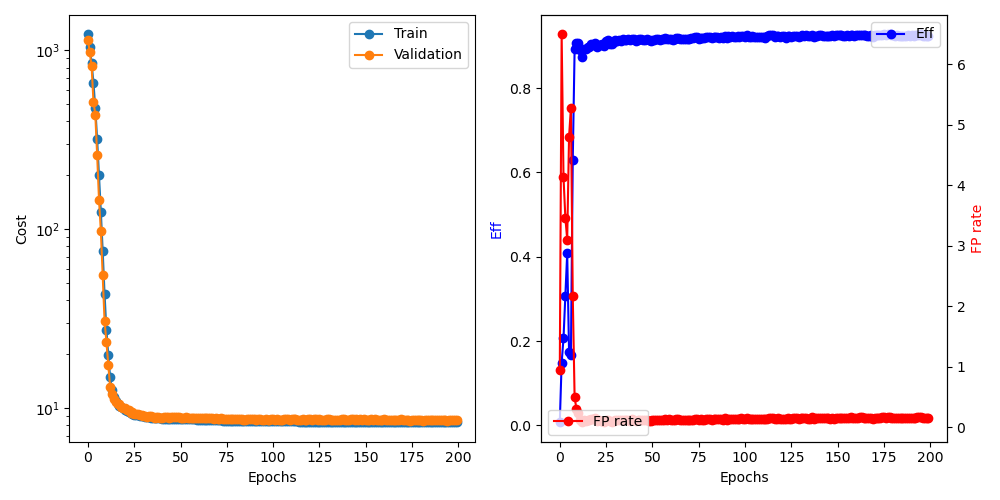

In [12]:
avgEff = 0.0
avgFP = 0.0
print('for model: ', model)   
run_name = 'Model Y (P3)'
# Create an mlflow run
with mlflow.start_run(run_name=run_name) as run:
    # Log parameters of the model
    for key, value in vars(args).items():
        print(key, value)
        mlflow.log_param(key, value)
    
    # Log parameter count in the model
    mlflow.log_param('Parameters', count_parameters(model))
    
    # Begin run
    for result in trainNet(model, optimizer, loss,
                            train_loader, val_loader,
                            args.epochs+args.epoch_start, epoch_start=args.epoch_start,
                            notebook=True, device=device):

        result = result._asdict()
        results = results.append(pd.Series(result), ignore_index=True)
        xs = results.index

        # Update the plot above
        lines['train'].set_data(results.index, results.cost)
        lines['val'].set_data(results.index, results.val)

        #filter first cost epoch (can be really large)
        max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
        min_cost = min(min(results.cost), min(results.val))
    
        # The plot limits need updating too
        ax.set_ylim(min_cost*.9, max_cost*1.1)  
        ax.set_xlim(-.5, len(results.cost) - .5)
    
        replace_in_ax(lax, lines['eff'], xs, results['eff_val'].apply(lambda x: x.eff_rate))
        replace_in_ax(tax, lines['fp'], xs, results['eff_val'].apply(lambda x: x.fp_rate)) 
            
        # Redraw the figure
        fig.canvas.draw()  
        
        ## MLFLOW ##
        # Log metrics
        mlflow.log_metric('Efficiency', result['eff_val'].eff_rate, result['epoch'])
        mlflow.log_metric('False Positive Rate',  result['eff_val'].fp_rate, result['epoch'])
        mlflow.log_metric('Validation Loss',  result['val'], result['epoch'])
        mlflow.log_metric('Training Loss',  result['cost'], result['epoch'])
        
        # computes averages for eff and fp of last 10 epochs
        print('Result epoch: ', result['epoch'])
        if(result['epoch'] >= args.epochs + args.epoch_start - 10):
            avgEff += result['eff_val'].eff_rate
            avgFP += result['eff_val'].fp_rate
           
        if(result['epoch'] == args.epochs + args.epoch_start - 1):
            print('Averaging...\n')
            avgEff /= 10
            avgFP /= 10
            mlflow.log_metric('10 Efficiency Average', avgEff)
            mlflow.log_metric('10 False Positive Average', avgFP)
            
        print('Average Eff: ', avgEff)
        print('Average FP Rate: ', avgFP)
            
        # Log tags
#        mlflow.set_tag('Optimizer', 'Adam')
#        mlflow.set_tag('Kernel size', 'Mixed')
#        mlflow.set_tag('Skip connections', '4')
#        mlflow.set_tag('Activation', 'Softplus')
#        mlflow.set_tag('Mid Activation', 'Relu')
        mlflow.set_tag('Asymmetry', '2.5')

        # Save model state dictionary, optimizer state dictionary, and epoch number
        torch.save({
            'model':model.state_dict(),
            'optimizer':optimizer.state_dict(),
            'epoch':args.epochs+result['epoch']
            }, 'run_stats.pyt')
        # Save the run stats into mlflow
        mlflow.log_artifact('run_stats.pyt')
        
    dual_train_plots(results.index,
                 results.cost, results.val, 
                 results['eff_val'].apply(lambda x: x.eff_rate),
                 results['eff_val'].apply(lambda x: x.fp_rate))
    plt.tight_layout()
    # save plot
    fig.savefig('plot.png')  
    mlflow.log_artifact('plot.png')

In [13]:
##quit()